<p style="font-size:30px; text-align:center; line-height:120%">
    <br> 
        <b>
        COMS 4995 Applied ML
            Homework 4 
        <br></br>
            Wine Reviews: Task 1
        <br></br>
        </b> 
    <br> 
</p>
<p style="font-size:18px; text-align:left; line-height:120%">
    <br> 
        <b>
        Name: Kirit Dhillon, Sagar Lal
        </b>
    <br> 
        <b>
        Uni: ksd2142, sl3946
        </b>
</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load in Data

In [2]:
data = pd.read_csv("winemag-data-130k-v2.csv")

# Task 1: Identify Features

### Explore which columns might be relevant

In [3]:
data.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

In [4]:
data

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,https://saltlakecity.craigslist.org,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,...,4wd,compact,hatchback,black,https://images.craigslist.org/00G0G_fTLDWM5Xyv...,PRICE REDUCED! -Garage kept -Low Miles (63K)...,NaN,ut,40.7372,-111.858
1,7034440610,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00v0v_7Cu0buIofU...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
2,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,46463,2015.0,gmc,sierra 1500,excellent,NaN,...,4wd,NaN,NaN,white,https://images.craigslist.org/01515_lPvJ9bfbdY...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
3,7034440546,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00T0T_6Rjfp3NS4O...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
4,7034406932,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,49999,2018.0,ford,f-450,NaN,NaN,...,4wd,NaN,pickup,white,https://images.craigslist.org/00W0W_8yIUwRBXXd...,2018 Ford F-350 F350 F 350 SD Lariat Crew Cab ...,NaN,ut,40.3744,-104.694
5,7034406582,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,13999,2009.0,ram,NaN,NaN,NaN,...,4wd,NaN,pickup,silver,https://images.craigslist.org/00y0y_RR9x2lk7eh...,"2009 RAM 1500 4WD Quad Cab 140.5"" ST"" Offe...",NaN,ut,40.3744,-104.694
6,7034405619,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,34500,2017.0,ford,f-350,NaN,NaN,...,4wd,NaN,pickup,white,https://images.craigslist.org/00k0k_lIBatiU90s...,2017 Ford Super Duty F-350 F350 F 350 SRW Crew...,NaN,ut,40.3744,-104.694
7,7034405349,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,14500,2007.0,gmc,sierra,NaN,NaN,...,4wd,NaN,pickup,NaN,https://images.craigslist.org/00202_jTNQzQVWZs...,2007 GMC Sierra 1500 SLE Crew Cab 4WD Offe...,NaN,ut,40.3744,-104.694
8,7034404595,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,12500,2013.0,ford,f-250,NaN,NaN,...,4wd,NaN,pickup,white,https://images.craigslist.org/00F0F_99lwfqrZWc...,2013 Ford F-250 F250 F 250 SD XLT 4WD Offe...,NaN,ut,40.3744,-104.694
9,7034401857,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,34500,2012.0,ram,NaN,NaN,NaN,...,4wd,NaN,pickup,silver,https://images.craigslist.org/00a0a_1cDSDtUsLA...,"2012 RAM 2500 4WD Mega Cab 160.5"" Laramie Long...",NaN,ut,40.3744,-104.694


### Columns Analysis

**Target Column = Price**

**Original Relevant Feature Columns**
- region
- year
- manufacturer
- model
- condition
- cylinders
- fuel
- odometer
- title status
- transmission
- drive
- size
- type
- paint_color
- state


**Removed Columns and Rationale**
- id = Column is unique for all and has no meaning relative to a car as it is generated by the dataset. It could also leak information in terms of the model learning ids, or perhaps the ids aren't truly random and instead reflect when the sale was added to the set.

- URL = Similar to above in that it has to be unique, it has no meaning about the car, and wouldn't impact people's behaviors regarding buying or selling.

- region_url = This information is redundant when we include region

- price = target variable and would directly leak information if included

- VIN = This value is a unique physical ID for all cars and is not information that a user would take into account when purchasing or selling

- image_url = Similar to the URL, it has no meaning about the car as it is only the place where the image is served to users. It shouldn't impact people's behaviors regarding buying or selling.

- descrpition = While it would definitely provide useful information, the assignment indicated not to analyze this feature (could run NLP sentiment analysis, etc)

- county = all NULL therefore we remove the value

- Lat/Long = This information is likely too detailed and users take into mainly the state and region where a car is being sold rather than the specific geo location

In [3]:
data = data[data['price']<1000000] #Only include cars that are less than $1mil since the rest are likely outliers

#Subset of data for faster experimentation
data_subset = data.sample(frac=0.1)

data_subset_x = data_subset.drop(['id', 'url', 'region_url', 'price', 'vin', 'image_url', 'description', 'county', 'lat', 'long'], axis=1)
data_subset_y = data_subset['price']

### Analyze chosen feature columns further to confirm true feature set

In [6]:
#Find Percent of Nans in each column to see if any clear ommisions
data_subset_x.isna().sum()/data.shape[0]*100

#None are too small so we keep all

region          0.000000
year            0.033366
manufacturer    0.448474
model           0.156623
condition       4.572870
cylinders       3.903396
fuel            0.079096
odometer        1.798020
title_status    0.060255
transmission    0.065750
drive           2.833535
size            6.725744
type            2.809197
paint_color     3.239811
state           0.000000
dtype: float64

In [7]:
#Visualize Price to Feature Relationships

#Fill na's for plotting purposes

fill_dict = {"region": "0", 
"year": 0.0,             
"manufacturer": "0",
"model": "0",
"condition": "0",
"cylinders": "0",
"fuel": "0",
"odometer": -1,  
"title_status": "0",     
"transmission": "0",     
"drive": "0",            
"size": "0",
"type": "0",
"paint_color": "0",
"state": "0"
            }

plot_data_subset = data.sample(frac=0.01)

plot_data_subset_x = plot_data_subset.drop(['id', 'url', 'region_url', 'price', 'vin', 'image_url', 'description', 'county', 'lat', 'long'], axis=1)
plot_data_subset_y = plot_data_subset['price']

plot_data_subset_x = plot_data_subset_x.fillna(value=fill_dict)

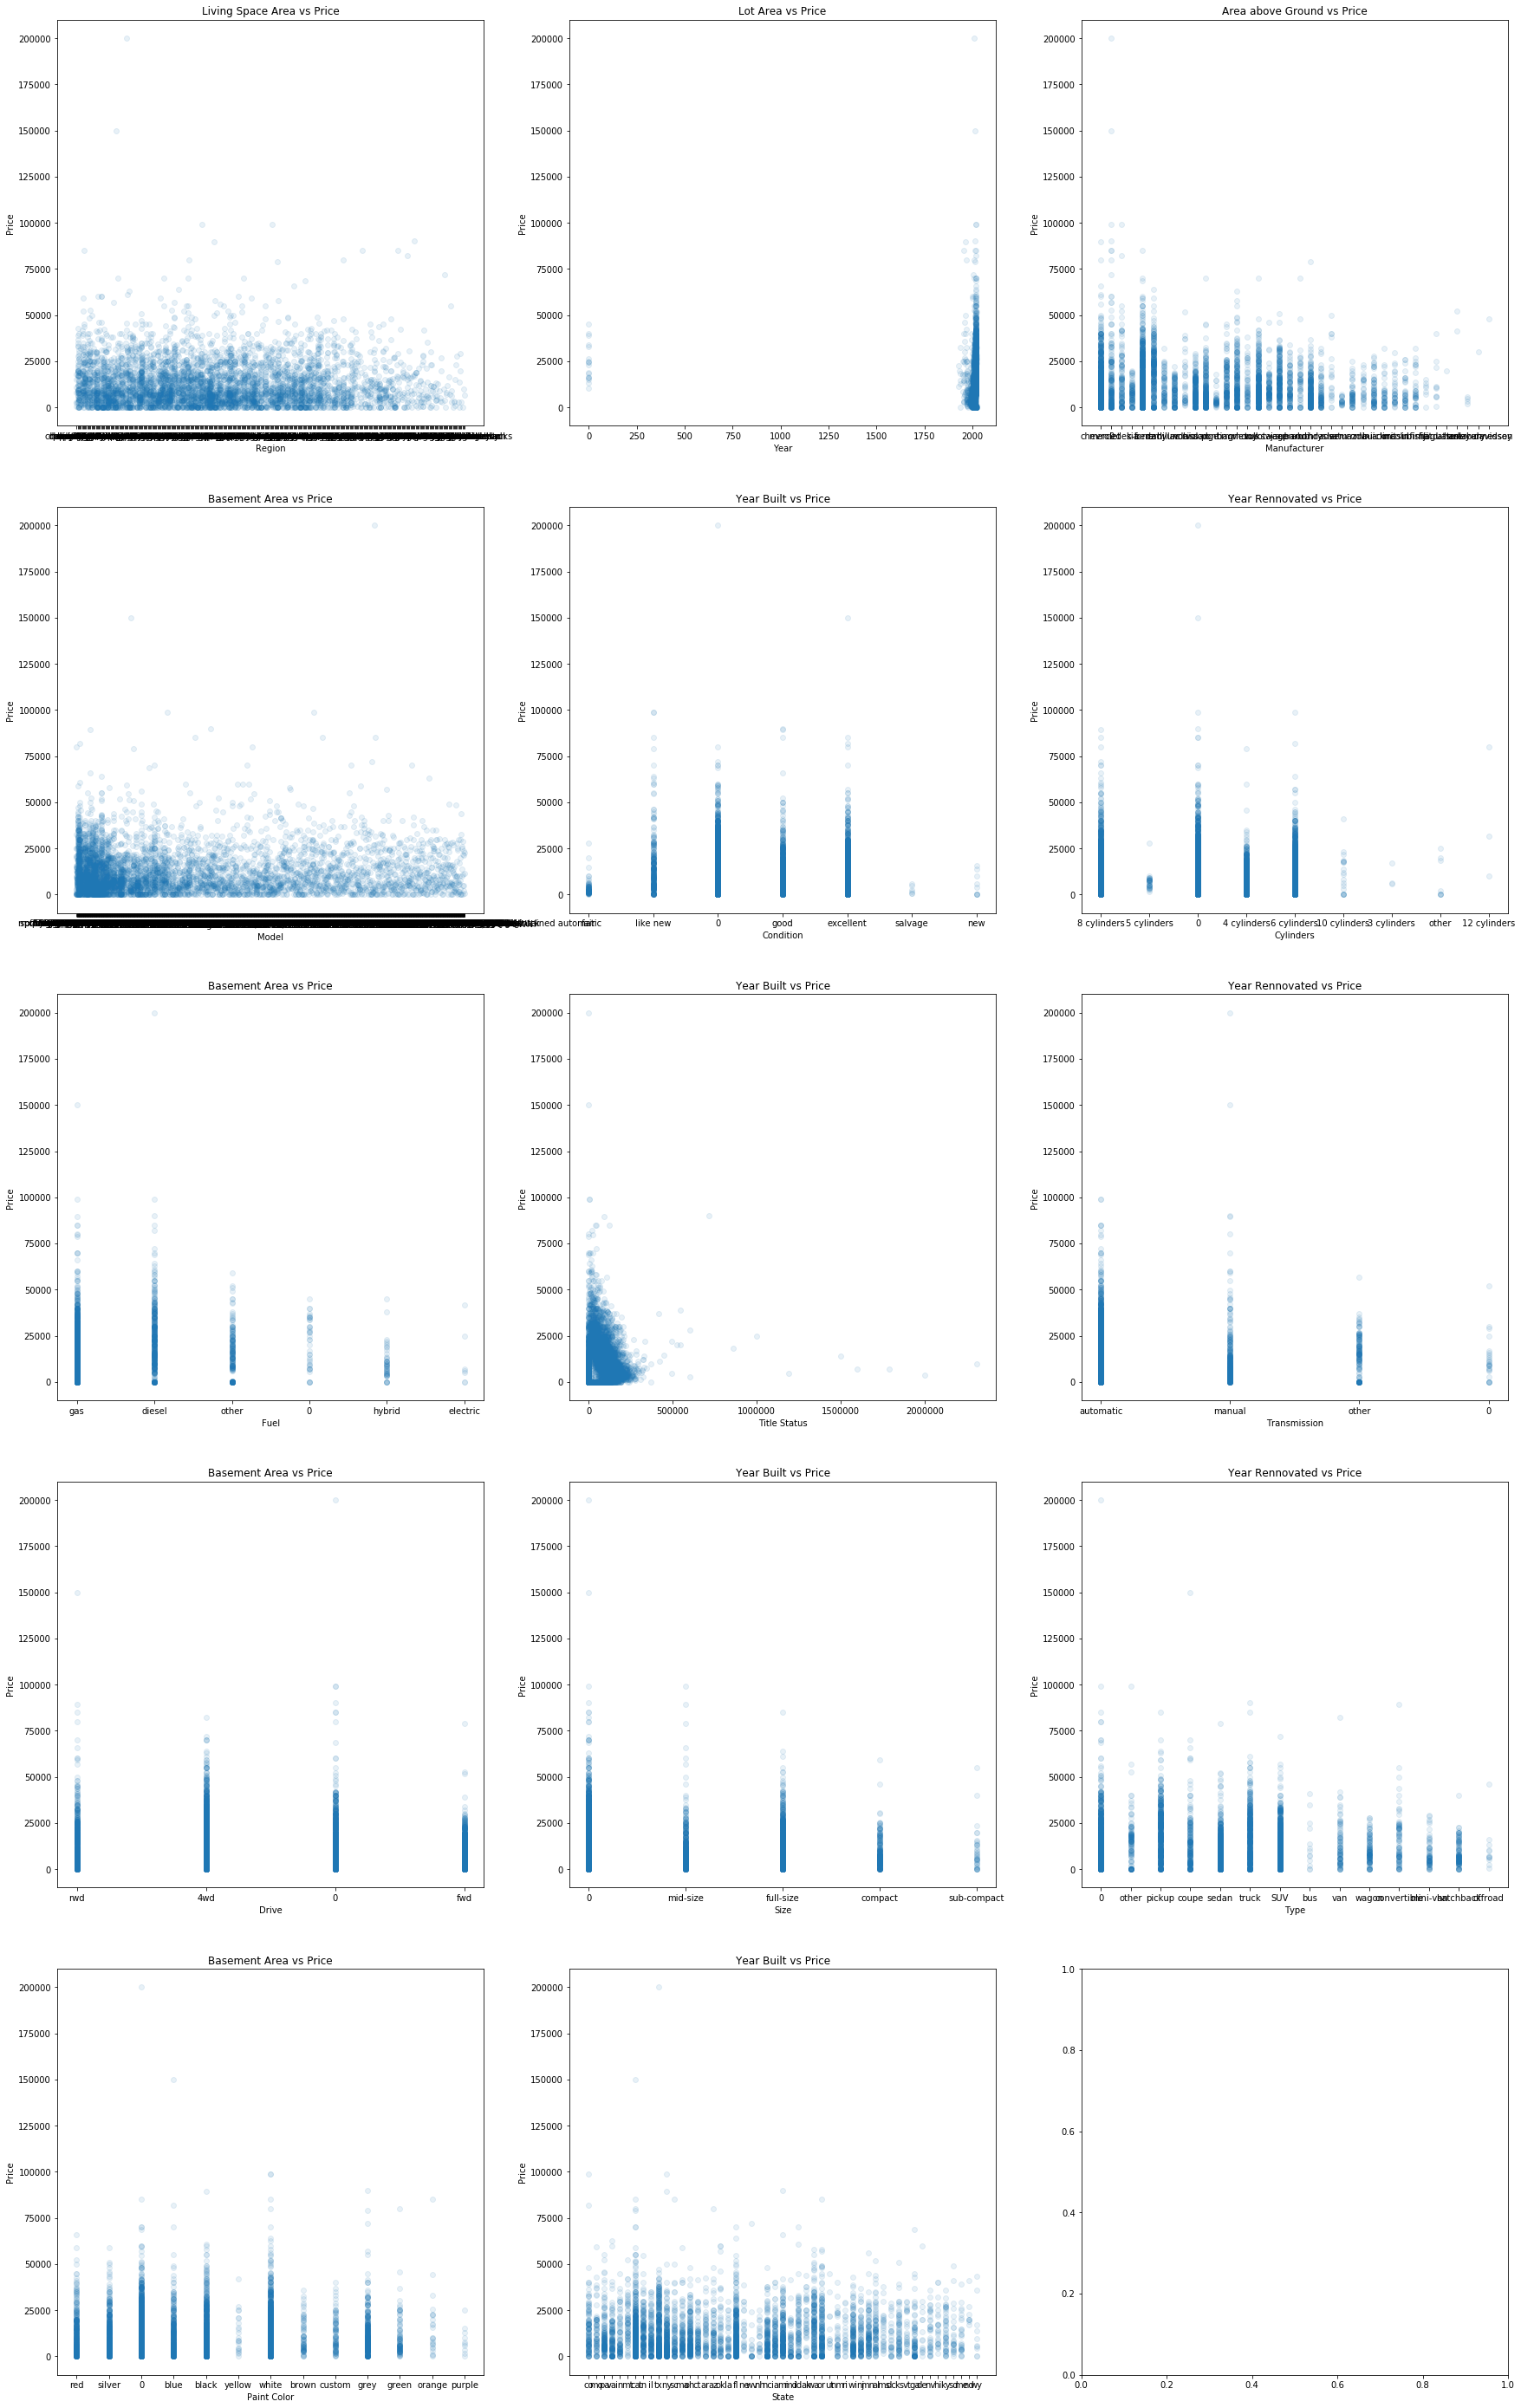

In [8]:
fig, ax = plt.subplots(5, 3, figsize=(30, 50)) 

ax[0,0].scatter(plot_data_subset_x['region'], plot_data_subset_y, alpha=0.1) 
ax[0,0].set_xlabel("Region")
ax[0,0].set_ylabel("Price")
ax[0,0].set_title("Living Space Area vs Price")

ax[0,1].scatter(plot_data_subset_x['year'], plot_data_subset_y, alpha=0.1) 
ax[0,1].set_xlabel("Year")
ax[0,1].set_ylabel("Price")
ax[0,1].set_title("Lot Area vs Price")

ax[0,2].scatter(plot_data_subset_x['manufacturer'], plot_data_subset_y, alpha=0.1) 
ax[0,2].set_xlabel("Manufacturer")
ax[0,2].set_ylabel("Price")
ax[0,2].set_title("Area above Ground vs Price")

ax[1,0].scatter(plot_data_subset_x['model'], plot_data_subset_y, alpha=0.1) 
ax[1,0].set_xlabel("Model")
ax[1,0].set_ylabel("Price")
ax[1,0].set_title("Basement Area vs Price")

ax[1,1].scatter(plot_data_subset_x['condition'], plot_data_subset_y, alpha=0.1)  
ax[1,1].set_xlabel("Condition")
ax[1,1].set_ylabel("Price")
ax[1,1].set_title("Year Built vs Price")

ax[1,2].scatter(plot_data_subset_x['cylinders'], plot_data_subset_y, alpha=0.1)  
ax[1,2].set_xlabel("Cylinders")
ax[1,2].set_ylabel("Price")
ax[1,2].set_title("Year Rennovated vs Price")

ax[2,0].scatter(plot_data_subset_x['fuel'], plot_data_subset_y, alpha=0.1) 
ax[2,0].set_xlabel("Fuel")
ax[2,0].set_ylabel("Price")
ax[2,0].set_title("Basement Area vs Price")

ax[2,1].scatter(plot_data_subset_x['odometer'], plot_data_subset_y, alpha=0.1)  
ax[2,1].set_xlabel("Title Status")
ax[2,1].set_ylabel("Price")
ax[2,1].set_title("Year Built vs Price")

ax[2,2].scatter(plot_data_subset_x['transmission'], plot_data_subset_y, alpha=0.1)  
ax[2,2].set_xlabel("Transmission")
ax[2,2].set_ylabel("Price")
ax[2,2].set_title("Year Rennovated vs Price")

ax[3,0].scatter(plot_data_subset_x['drive'], plot_data_subset_y, alpha=0.1) 
ax[3,0].set_xlabel("Drive")
ax[3,0].set_ylabel("Price")
ax[3,0].set_title("Basement Area vs Price")

ax[3,1].scatter(plot_data_subset_x['size'], plot_data_subset_y, alpha=0.1)  
ax[3,1].set_xlabel("Size")
ax[3,1].set_ylabel("Price")
ax[3,1].set_title("Year Built vs Price")

ax[3,2].scatter(plot_data_subset_x['type'], plot_data_subset_y, alpha=0.1)  
ax[3,2].set_xlabel("Type")
ax[3,2].set_ylabel("Price")
ax[3,2].set_title("Year Rennovated vs Price")

ax[4,0].scatter(plot_data_subset_x['paint_color'], plot_data_subset_y, alpha=0.1) 
ax[4,0].set_xlabel("Paint Color")
ax[4,0].set_ylabel("Price")
ax[4,0].set_title("Basement Area vs Price")

ax[4,1].scatter(plot_data_subset_x['state'], plot_data_subset_y, alpha=0.1)  
ax[4,1].set_xlabel("State")
ax[4,1].set_ylabel("Price")
ax[4,1].set_title("Year Built vs Price")

plt.show()

### Analyze Plots

All plots seem to have a non-uniform distribution across the values in terms of the price. This indicates to us that they should all provide some information regarding the price of a car. The existence of a distribution, and based our initial removal, indicates we have avoided leaking information. The visualizations also indicate to us that the imputation of the missing values (0 in the plots) will be quite important in how our models perform

# Task 2: Preprocessing and Baseline Model
<br>
For task 2, we decided to impute the missing values and doing One-Hot Encoding/Standard Scaling for the continuous and categorical variables respectively. We experimented with different imputing types for the continuous variables and determined median was better

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
X_trainval, X_test, y_trainval, y_test = train_test_split(data_subset_x, data_subset_y)

continuous_features = ['year', 'odometer']
categorical_features = ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
                        'title_status', 'transmission', 'drive', 'size','type', 'paint_color',
                        'state']

In [12]:
%%time
base_categorical_transformer = Pipeline(steps=[('simpleimputer', SimpleImputer(strategy = 'constant', fill_value = "missing")),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

base_continuous_transformer = Pipeline(steps=[('simpleimputer', SimpleImputer(strategy = "median")),
                                         ('scaler', StandardScaler())])

base_continuous_and_categorical_preprocessor = ColumnTransformer(
    transformers=[
        ('num', base_continuous_transformer, continuous_features),
        ('cat', base_categorical_transformer, categorical_features)
    ])

base_ridge_clf = Pipeline(steps=[('preprocessor', base_continuous_and_categorical_preprocessor),
                                ('classifier', Ridge())])

base_ridge_scores = cross_val_score(base_ridge_clf, X_trainval, y_trainval, cv=5)

print("Base Ridge Model CV mean score: ", np.mean(base_ridge_scores))

Base Ridge Model CV mean score:  0.3849520322776724
CPU times: user 2.45 s, sys: 151 ms, total: 2.6 s
Wall time: 2.6 s


# Task 3: Feature Engineering

- We attempt to use target encoding and polynomial features independently to see if they improve performance

In [13]:
X_trainval.nunique()

region            401
year              100
manufacturer       40
model            7850
condition           6
cylinders           8
fuel                5
odometer        20832
title_status        6
transmission        3
drive               3
size                4
type               13
paint_color        12
state              51
dtype: int64

In [11]:
%%time
### Experiment with target encoding suggests that any subset of columns used for target encoding drops performance


from category_encoders import TargetEncoder

better_target_cols = ['condition', ]
better_cat_cols = ['manufacturer', 'type', 'model', 'region', 'title_status','cylinders', 'paint_color',  'fuel', 'transmission', 'drive', 'size','state' ]
better_cont_cols = continuous_features

#Relabel variables

better_categorical_transformer = Pipeline(steps=[('simpleimputer', SimpleImputer(strategy = 'constant', fill_value = "missing")),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

better_target_transformer = Pipeline(steps=[('simpleimputer', SimpleImputer(strategy = 'constant', fill_value = "missing")),
                                          ('target', TargetEncoder())])

better_continuous_transformer = Pipeline(steps=[('simpleimputer', SimpleImputer(strategy = "median")),
                                         ('scaler', StandardScaler())])

better_continuous_and_categorical_preprocessor = ColumnTransformer(
    transformers=[
        ('num', better_continuous_transformer, better_cont_cols),
        ('target', better_target_transformer, better_target_cols),
        ('cat', better_categorical_transformer, better_cat_cols)
    ])

better_ridge_clf = Pipeline(steps=[('preprocessor', better_continuous_and_categorical_preprocessor),
                                ('classifier', Ridge())])

better_ridge_scores = cross_val_score(better_ridge_clf, X_trainval, y_trainval, cv=5)

print("Improved Ridge Model CV mean score: ", np.mean(better_ridge_scores))

Improved Ridge Model CV mean score:  0.3587986637595183
CPU times: user 2.57 s, sys: 189 ms, total: 2.76 s
Wall time: 2.85 s


In [ ]:
%%time
#Testing Polynomial features
from sklearn.preprocessing import PolynomialFeatures

base_categorical_transformer = Pipeline(steps=[('simpleimputer', SimpleImputer(strategy = 'constant', fill_value = "missing")),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

base_continuous_transformer = Pipeline(steps=[('simpleimputer', SimpleImputer(strategy = "median")),
                                         ('scaler', StandardScaler())])

base_continuous_and_categorical_preprocessor = ColumnTransformer(
    transformers=[
        ('num', base_continuous_transformer, continuous_features),
        ('cat', base_categorical_transformer, categorical_features)
    ])

base_ridge_clf = Pipeline(steps=[('preprocessor', base_continuous_and_categorical_preprocessor),
                                 ('polynomial', PolynomialFeatures(2)),
                                ('classifier', Ridge())])

base_ridge_scores = cross_val_score(base_ridge_clf, X_trainval, y_trainval, cv=5)

print("Base Ridge Model CV mean score: ", np.mean(base_ridge_scores))

### Analysis

Indepdently adding polynomial features and target encoding didn't improve performance. Specifically, it lowered mean CV score from .38 to .35 for target encoding and from .38 to .29 for polynomial features while also taking extremely long time (the performance was cleared by accident and we didn't want to spend hours re-running).

# Task 4: Improve With Any Model

As you can see below, we tried several different regression models like linear regression, random forests, ridge regression, elastic net, SVR, and gradient boosting. We also tuned hyperparameters by doing a thorough search with GridSearchCV.
- Gradient boosting with XGBoost gives the best and most efficient accuracy (0.59), followed by ridge regression (0.41) and linear regression (0.38). 
- Random forest regressor took north of 6 hours to train compared to minutes for the other models.
- SVR performs really poorly. (-0.08).

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet

In [14]:
%%time
lin_pipeline = Pipeline(steps=[('preprocessor', base_continuous_and_categorical_preprocessor),
                                ('regressor', LinearRegression())])

param_grid =  {
               'regressor__fit_intercept': [True, False]
              }
grid = GridSearchCV(lin_pipeline, param_grid, cv=5, return_train_score=True)
grid.fit(X_trainval, y_trainval)

print(("Basic linear reg score %.2f"
       %grid.score(X_test, y_test)))
print("Best param:", grid.best_params_)

Basic linear reg score 0.38
Best param: {'regressor__fit_intercept': True}
CPU times: user 2min 4s, sys: 11.2 s, total: 2min 15s
Wall time: 3min 52s


In [ ]:
%%time
#After 4+ hrs this model still did not fit, therefore there are no results

rf_pipeline = Pipeline(steps=[('preprocessor', base_continuous_and_categorical_preprocessor),
                              ('regressor', RandomForestRegressor())])

param_grid =  {
               'regressor__max_features': ['auto', 'sqrt'],
               'regressor__min_samples_split': min_samples_split = [2, 10]
              }
grid = GridSearchCV(rf_pipeline, param_grid, cv=5, return_train_score=True)
grid.fit(X_trainval, y_trainval)

print(("RF reg score %.2f"
       %grid.score(X_test, y_test)))
print("Best param:", grid.best_params_)


In [15]:
%%time
ridge_pipeline = Pipeline(steps=[('preprocessor', base_continuous_and_categorical_preprocessor),
                                ('regressor', Ridge())])

param_grid =  {
               'regressor__alpha': [0.01, 0.1, 1, 10, 100]
                
              }
grid = GridSearchCV(ridge_pipeline, param_grid, cv=3, return_train_score=True)
grid.fit(X_trainval, y_trainval)

print(("Ridge score %.2f"
       %grid.score(X_test, y_test)))
print("Best param:", grid.best_params_)

Ridge score 0.41
Best param: {'regressor__alpha': 1}
CPU times: user 12.5 s, sys: 1.08 s, total: 13.6 s
Wall time: 22.9 s


In [16]:
%%time
en_pipeline = Pipeline(steps=[('preprocessor', base_continuous_and_categorical_preprocessor),
                                ('regressor', ElasticNet())])
param_grid = {
               'regressor__alpha': [0.01, 0.1]
             }
grid = GridSearchCV(en_pipeline, param_grid, cv=3, return_train_score=True)
grid.fit(X_trainval, y_trainval)

print(("ElasticNet score %.2f"
       %grid.score(X_test, y_test)))
print("Best param:", grid.best_params_)

ElasticNet score 0.31
Best param: {'regressor__alpha': 0.01}
CPU times: user 7min 9s, sys: 13.4 s, total: 7min 23s
Wall time: 10min 33s


In [19]:
%%time
#SVR peformed terribly
svr_pipeline = Pipeline(steps=[('preprocessor', base_continuous_and_categorical_preprocessor),
                                ('regressor', SVR())])
param_grid =  {
               'regressor__C': [0.01, 0.1]
              }
grid = GridSearchCV(svr_pipeline, param_grid, cv=3, return_train_score=True)
grid.fit(X_trainval, y_trainval)

print(("SVR score %.2f"
       %grid.score(X_test, y_test)))
print("Best param:", grid.best_params_)

SVR score -0.08
Best param: {'regressor__C': 0.1}
CPU times: user 18min 21s, sys: 16 s, total: 18min 37s
Wall time: 20min 54s


In [8]:
%%time
from xgboost import XGBRegressor

xgbr_pipeline = Pipeline(steps=[('preprocessor', base_continuous_and_categorical_preprocessor),
                                ('regressor', XGBRegressor())])
param_grid =  {
               'regressor__max_depth': [4,7,10],
               "regressor__alpha": [0, 0.5, 2],
               "regressor__lambda": [0.5, 1, 3],
    
              }
xgb_grid = GridSearchCV(xgbr_pipeline, param_grid, cv=3, return_train_score=True)
xgb_grid.fit(X_trainval, y_trainval)

print(("XGBR score %.2f"
       %xgb_grid.score(X_test, y_test)))
print("Best param:", xgb_grid.best_params_)

XGBR score 0.59
Best param: {'regressor__alpha': 0.5, 'regressor__lambda': 3, 'regressor__max_depth': 10}
CPU times: user 10min 34s, sys: 9.85 s, total: 10min 44s
Wall time: 11min 18s


### Summary
XGBoost performed the best relative to all other models displayed above. While we tried the preprocessing that we tried in step 3, it did not improve performance therefore we do not include it. Instead the base preprocessing used for task 2 is used.

# Task 5: Feature Selections

In [22]:
from xgboost import plot_importance
from sklearn.inspection import permutation_importance

In [46]:
#Use permutation importance which computes via XGB's default scorer. In this case the default is R2 (coefficient of determination)
importance = permutation_importance(xgb_grid.best_estimator_, X_test, y_test)
importance = np.array([list(X_test.columns), list(importance['importances_mean'])])

feature_importances = pd.DataFrame(importance.T, columns = ['Feature Name', 'Average R2 Score'])
feature_importances['Average R2 Score'] = feature_importances['Average R2 Score'].astype('float')

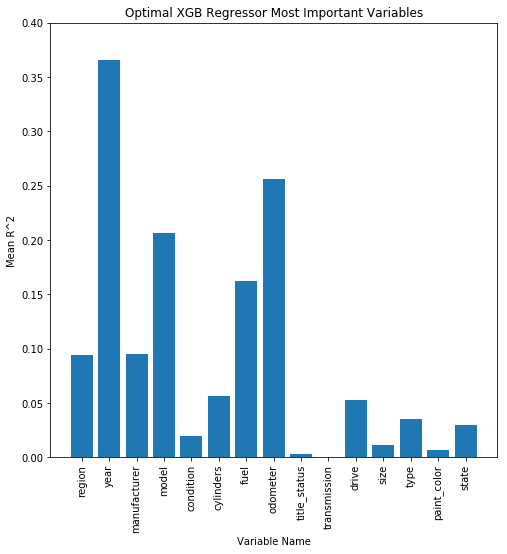

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 
ax.bar(feature_importances['Feature Name'], feature_importances['Average R2 Score'])
ax.set_xlabel("Variable Name")
ax.set_ylabel("Mean R^2")
ax.set_title("Optimal XGB Regressor Most Important Variables") 
ax.set_ylim([0, 0.4]) 
ax.set_xticklabels(labels=feature_importances['Feature Name'], rotation='vertical')

plt.show()

#### Analysis
We see that title_status, transmission, paint color, size are not particularly useful and re-run the model without those variables. Note since the coefficient of determination (R^2) is positive for all variables (it can be negative) we expect the model to decrease slightly in performance without these variables.

In [59]:
small_X_trainval = X_trainval.drop(['title_status', 'transmission', 'paint_color', 'size'], axis=1)
small_X_test = X_test.drop(['title_status', 'transmission', 'paint_color', 'size'], axis=1)

In [65]:
small_continuous_features = ['year', 'odometer']
small_categorical_features = ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'drive', 'type', 'state']


small_base_categorical_transformer = Pipeline(steps=[('simpleimputer', SimpleImputer(strategy = 'constant', fill_value = "missing")),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

small_base_continuous_transformer = Pipeline(steps=[('simpleimputer', SimpleImputer(strategy = "median")),
                                         ('scaler', StandardScaler())])

small_base_continuous_and_categorical_preprocessor = ColumnTransformer(
    transformers=[
        ('num', small_base_continuous_transformer, small_continuous_features),
        ('cat', small_base_categorical_transformer, small_categorical_features)
    ])

In [70]:
%%time
from xgboost import XGBRegressor

small_xgbr_pipeline = Pipeline(steps=[('preprocessor', small_base_continuous_and_categorical_preprocessor),
                                ('regressor', XGBRegressor())])
param_grid =  {
               'regressor__max_depth': [10],
               "regressor__alpha": [0.5],
               "regressor__lambda": [3],
    
              }
small_xgb_grid = GridSearchCV(small_xgbr_pipeline, param_grid, cv=3, return_train_score=True)
small_xgb_grid.fit(small_X_trainval, y_trainval)

print(("XGBR score %.2f"
       %small_xgb_grid.score(small_X_test, y_test)))
print("Best param:", small_xgb_grid.best_params_)

XGBR score 0.58
Best param: {'regressor__alpha': 0.5, 'regressor__lambda': 3, 'regressor__max_depth': 10}
CPU times: user 39.9 s, sys: 658 ms, total: 40.6 s
Wall time: 46.1 s


#### Analysis
As expected, removing the less meaningful columns didn't improve performance. In fact the model drops in performance ever so slightly. This is because the features that we removed weren't harming the model; they were improving it. Note given our metric choice, it was possible to have features that hurt the model. We want to see if the smaller subset of featurse changed which features were most prominent

In [71]:
#Use permutation importance which computes via XGB's default scorer. In this case the default is R2 (coefficient of determination)
importance = permutation_importance(small_xgb_grid.best_estimator_, small_X_test, y_test)

importance = np.array([list(small_X_test.columns), list(importance['importances_mean'])])

feature_importances = pd.DataFrame(importance.T, columns = ['Feature Name', 'Average R2 Score'])
feature_importances['Average R2 Score'] = feature_importances['Average R2 Score'].astype('float')

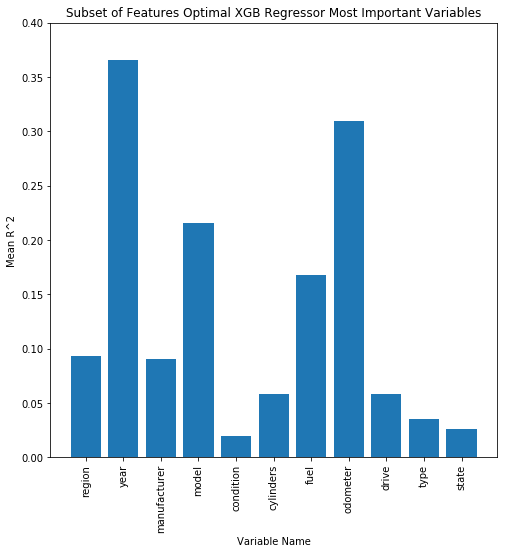

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 
ax.bar(feature_importances['Feature Name'], feature_importances['Average R2 Score'])
ax.set_xlabel("Variable Name")
ax.set_ylabel("Mean R^2")
ax.set_title("Subset of Features Optimal XGB Regressor Most Important Variables") 
ax.set_ylim([0, 0.4]) 
ax.set_xticklabels(labels=feature_importances['Feature Name'], rotation='vertical')

plt.show()

# Task 6: An Explainable Model

While we feel that the above model and feature visualization was quite explainable in terms what the varying impacts of features, we will demonstrate conducting a simpler analysis on a Lasso regressor with large C to ensure that fewer features end up with non-zero coefficients. This model, however, will perform quite a bit worse. We wanted to try out Tree based models (ExtraTrees/Rf/Decision trees) but consistently found that they took too long (4+ hrs) to fit and decided against using them.

In [75]:
%%time
lasso_pipeline = Pipeline(steps=[('preprocessor', base_continuous_and_categorical_preprocessor),
                                ('regressor', Lasso())])

param_grid =  {
               'regressor__alpha': [10, 100, 1000]
                
              }
lasso_grid = GridSearchCV(lasso_pipeline, param_grid, cv=3, return_train_score=True)
lasso_grid.fit(X_trainval, y_trainval)

print(("Lasso score %.2f"
       %lasso_grid.score(X_test, y_test)))
print("Best param:", grid.best_params_)

Lasso score 0.29
Best param: {'regressor__alpha': 10}
CPU times: user 1min 7s, sys: 2.05 s, total: 1min 9s
Wall time: 1min 2s


In [79]:
lasso_coefs = lasso_grid.best_estimator_['regressor'].coef_

In [93]:
column_names = list(lasso_pipeline['preprocessor'].transformers_[1][1]['onehot']\
                         .get_feature_names(categorical_features)) + continuous_features

In [97]:
coef_names = pd.DataFrame(np.array([lasso_coefs,column_names]).T,columns=['Coefficient', 'Feature Name'])
coef_names = coef_names[['Feature Name', 'Coefficient']]

In [102]:
coef_names

,Feature Name,Coefficient
0,region_SF bay area,2566.1425051194615
1,region_abilene,-2078.122564484124
2,region_akron / canton,880.3652004305087
3,region_albany,0.0
4,region_albuquerque,0.0
5,region_altoona-johnstown,0.0
6,region_amarillo,0.0
7,region_ames,-0.0
8,region_anchorage / mat-su,0.0
9,region_ann arbor,0.0


In [105]:
magnitude = coef_names.to_numpy()

In [159]:
abs_mag = magnitude[:,1].astype(float)
abs_mag = np.abs(abs_mag)
top_coeficients = magnitude[np.argsort(abs_mag)[-20:]]

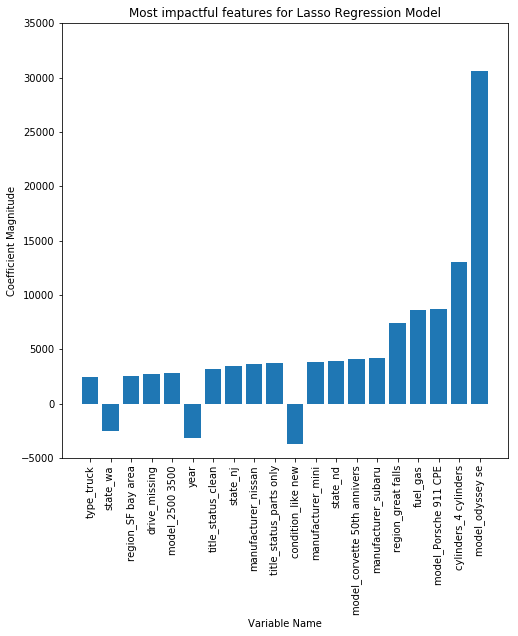

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 
ax.bar(top_coeficients[:,0], top_coeficients[:,1].astype(float))
ax.set_xlabel("Variable Name")
ax.set_ylabel("Coefficient Magnitude")
ax.set_title("Most impactful features for Lasso Regression Model") 
ax.set_ylim([-5000, 35000]) 
ax.set_xticklabels(labels=top_coeficients[:,0], rotation='vertical')

plt.show()

#### Analysis 
The figure above demonstrates that we can in fact, create another explainable model that's small enough to be easily inspected. Features like 'model_odyssey se', 'cylinders_4 cylinders', 'region_great falls', 'fuel_gas' are most valuable. Note that the most important coefficients of the XGBoost model (year, odometer) were different. This shows that one should try several models in order to understand feature importances. 